# AI-Generated Image Detection

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import pandas as pd
import seaborn as sns

import pathlib
from zipfile import ZipFile
import imagehash
import random

### 1.   Importing the Data

- Since the data is in a zip file, It needs to be unzipped to access the images

In [2]:
# Unzip folder
zip_object = ZipFile('datasets/dataset2.zip', 'r')
zip_object.extractall()

-   The data come by default with a training and testing already established

In [3]:
# Storing image data into variables
train_dir = pathlib.Path('train/').with_suffix('')
test_dir = pathlib.Path('test/').with_suffix('')

In [4]:
train_img_array, test_img_array = list(train_dir.glob('*/*')), list(test_dir.glob('*/*'))
total_dataset = train_img_array + test_img_array

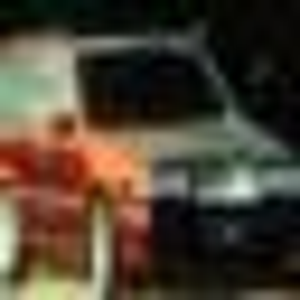

In [5]:
# Display random image in the dataset
random_number = random.randint(0, len(train_img_array))
Image.open(str(train_img_array[random_number])).resize((300, 300))

#### Information about the dataset

In [6]:
# Check the number of items in the dataset
print(f"Training image count : {len(train_img_array)} \nTesting image count : {len(test_img_array)} \nTotal data : {len(total_dataset)}")

Training image count : 100000 
Testing image count : 20000 
Total data : 120000


In [7]:
# Check the number of type image extension in the dataset
image_types = [
    {"file_type": "jpeg", "count": 0},
    {"file_type": "png", "count": 0},
    {"file_type": "jpg", "count": 0},
    {"file_type": "other", "count": 0},
]

# train_image_types = [
#     {"file_type": "jpeg", "count": 0},
#     {"file_type": "png", "count": 0},
#     {"file_type": "jpg", "count": 0},
#     {"file_type": "other", "count": 0},
# ]

# test_image_types = [
#     {"file_type": "jpeg", "count": 0},
#     {"file_type": "png", "count": 0},
#     {"file_type": "jpg", "count": 0},
#     {"file_type": "other", "count": 0},
# ]

def count_filetype(dataset, type_array):
    type_count = len(type_array)
    for c, file_name in enumerate(dataset):
        # Split the file name by the period (.) character
        parts = str(file_name).split(".")
        file_extension = str(parts[-1]).lower() # Get the extension type.
        # print("outer loop : ", c)
        for counter in range(type_count):
            # print("inner loop : ", counter)
            if file_extension == type_array[counter]["file_type"]:
                type_array[counter]["count"]+=1
                break
            if counter == (type_count - 1): # If the loop falls in the "other category"
                type_array[-1]["count"]+=1


# Counts image types occurrence for dataset 
count_filetype(total_dataset, image_types)

# Counts image types occurrence for training set 
# count_filetype(train_img_array, train_image_types)

# Counts image types occurrence for testing set 
# count_filetype(test_img_array, test_image_types)


# Display result for train dataset
for image_type in image_types:
  print(f"Number of {image_type['file_type']} images inside the dataset : {image_type['count']}")
  
# # Display result for train dataset
# for image_type in train_image_types:
#   print(f"Number of {image_type['file_type']} images inside the training dataset : {image_type['count']}")

# print("----------------------------------------------")
# Display result for test dataset
# for image_type in test_image_types:
#   print(f"Number of {image_type['file_type']} images inside the testing dataset : {image_type['count']}")

Number of jpeg images inside the dataset : 0
Number of png images inside the dataset : 0
Number of jpg images inside the dataset : 120000
Number of other images inside the dataset : 0


- We can observe that the dataset only contains jpg images in both the training and testing dataset

### 2.  Data cleaning

#### Check if the dataset contains corrupted and duplicated images.

In [8]:
def clean_image_data(dataset: list):
    # cleaned_images = []
    cleaned_images = 0
    # corrupted_images = []
    corrupted_images = 0
    imgs_shape = []  
    hash_dict = {}
    # duplicate_images = []  
    duplicate_images = 0  
    temp_dataset: list[bool] = [] 

    for count, filename in enumerate(dataset):
        filename = str(filename)
        try:
            with Image.open(filename) as img:
                # Optionally, perform additional checks such as size, format, etc.
                # Check image size
                # if img.size < min_size:
                #     print(f"Ignoring small image: {filename}")
                #     continue
                
                # print("image size : ", img.size)
                
                # img_width.append(img.size[0])
                # img_height.append(img.size[1])
                # Calculate the hash of the image
                img_hash = imagehash.average_hash(img)

                # Check if the hash already exists in the dictionary
                if img_hash in hash_dict:
                    duplicate_images+=1
                    temp_dataset.append(True)
                    # duplicate_images.append([filename, True])
                else:
                    hash_dict[img_hash] = filename
                    temp_dataset.append(False)
                    
                imgs_shape.append(img.size)
                cleaned_images+=1
                # cleaned_images.append(filename)
        except Exception as e:
            # Handle corrupted or unreadable images
            # corrupted_images.append(filename)
            corrupted_images+=1
            print(f"Corrupted image: {filename}, Error: {e}")

    return cleaned_images, corrupted_images, duplicate_images, temp_dataset, imgs_shape
# , img_width, img_height

# data_directory = train_img_array
cleaned_images, corrupted_images, duplicate_images, duplicates_values, imgs_shape = clean_image_data(total_dataset)
# , img_width, img_height = clean_image_data(total_dataset)

print(f"Cleaned images: {cleaned_images}")
print(f"Corrupted images: {corrupted_images}")
print("duplicate images : ", duplicate_images )
# print("duplicate images : ", hash_dict )

Cleaned images: 120000
Corrupted images: 0
duplicate images :  3342


- We observe that the dataset does not contain any corrupted image
- However duplicates images are in the dataset.

- Duplicated images are based on the image content rather than filenames. 
- The process to find duplicated images is as follows:
    - Turn the image content into a hash value and get the average value of the hash.
    - Compare images hash value and determine if there are duplicate or near-duplicate images based on similarity thresholds.

In [9]:
# Transforming the dataset list into a pandas.Series Dataframe 
df = pd.DataFrame(total_dataset, columns=["Filename"])
shapes = pd.DataFrame(imgs_shape, columns=["width", "height"])
dupl = pd.DataFrame(duplicates_values, columns=["duplicated"])

df = df.merge(shapes, left_index=True, right_index=True)

# merge_df = df.merge(dupl, left_index=True, right_index=True)

In [10]:
# Remove duplicates
print("Before Duplicates :", len(df))

df = df[~dupl["duplicated"]]

print("After removing duplicates :", len(df))

Before Duplicates : 120000
After removing duplicates : 116658


In [11]:
# reset index num 
df.reset_index(drop=True)

,Filename,width,height
0,train/REAL/4053 (9).jpg,32,32
1,train/REAL/2864 (4).jpg,32,32
2,train/REAL/3536 (3).jpg,32,32
3,train/REAL/0183 (8).jpg,32,32
4,train/REAL/1607 (8).jpg,32,32
...,...,...,...
116653,test/FAKE/357 (8).jpg,32,32
116654,test/FAKE/612.jpg,32,32
116655,test/FAKE/603 (9).jpg,32,32
116656,test/FAKE/282.jpg,32,32


In [12]:
df.shape

(116658, 3)

In [13]:
# creating new columns to tag data inside the dataset
df["folder_type"] = df["Filename"].apply(lambda x: "Test" if str(x).split("/")[0] == "test" else "Train") 
df["tag"] = df["Filename"].apply(lambda x: "REAL" if str(x).split("/")[1] == "REAL" else "FAKE") 

In [14]:
df.head()

,Filename,width,height,folder_type,tag
0,train/REAL/4053 (9).jpg,32,32,Train,REAL
1,train/REAL/2864 (4).jpg,32,32,Train,REAL
2,train/REAL/3536 (3).jpg,32,32,Train,REAL
3,train/REAL/0183 (8).jpg,32,32,Train,REAL
4,train/REAL/1607 (8).jpg,32,32,Train,REAL


### 3.  Data exploration

In [15]:
# Displays metrics about numerical data
df.describe()

,width,height
count,116658.0,116658.0
mean,32.0,32.0
std,0.0,0.0
min,32.0,32.0
25%,32.0,32.0
50%,32.0,32.0
75%,32.0,32.0
max,32.0,32.0


In [16]:
df.shape

(116658, 5)

In [17]:
df.apply(pd.Series.unique)

Filename       [train/REAL/4053 (9).jpg, train/REAL/2864 (4)....
width                                                       [32]
height                                                      [32]
folder_type                                        [Train, Test]
tag                                                 [REAL, FAKE]
dtype: object

- From this data we observe that all the images in the dataset are set in 32x32 pixels

In [18]:
# Displays metrics about non-numerical data
df.describe(include=['object'])

,Filename,folder_type,tag
count,116658,116658,116658
unique,116658,2,2
top,train/REAL/4053 (9).jpg,Train,REAL
freq,1,97536,59123


In [19]:
# Get the number of "REAL" and "FAKE" tags
num_real_tags = df["tag"].apply(lambda x: x.count("REAL")).sum()
num_fake_tags = df["tag"].apply(lambda x: x.count("FAKE")).sum()

num_train_real = df[df["folder_type"] == "Train"]["tag"].apply(lambda x: x.count("REAL")).sum()
num_train_fake = df[df["folder_type"] == "Train"]["tag"].apply(lambda x: x.count("FAKE")).sum()

num_test_real = df[df["folder_type"] == "Test"]["tag"].apply(lambda x: x.count("REAL")).sum()
num_test_fake = df[df["folder_type"] == "Test"]["tag"].apply(lambda x: x.count("FAKE")).sum()

# Get the number of "Train" and "Test" type
num_train = df["folder_type"].apply(lambda x: x.count("Train")).sum()
num_test = df["folder_type"].apply(lambda x: x.count("Test")).sum()

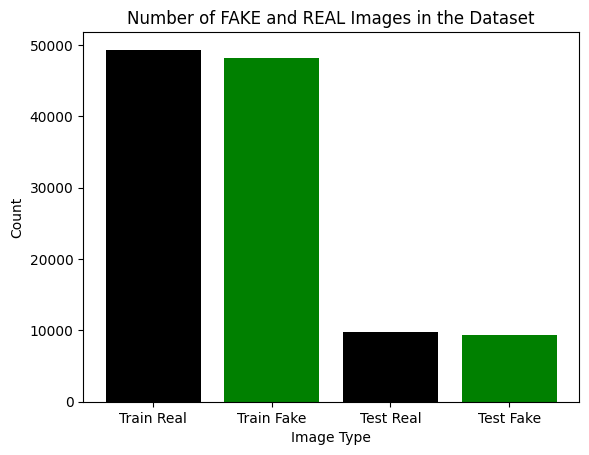

Number of 'FAKE' images: 57535
Number of 'REAL' images: 59123
Difference of 1588 images


In [20]:
# Create a bar chart
plt.bar(['Train Real', 'Train Fake', "Test Real", "Test Fake"], [num_train_real, num_train_fake, num_test_real, num_test_fake], color=["black", "green"])
plt.xlabel('Image Type')
plt.ylabel('Count')
plt.title('Number of FAKE and REAL Images in the Dataset')
# colors = {'Train Real': ['black', 'green', 'blue']}
# labels = list(colors.keys())
# handles = [plt.Rectangle((0,0),1,1, color=colors[label]) for label in labels]
# plt.legend(handles, labels)
plt.show()
print("Number of 'FAKE' images:", num_fake_tags)
print("Number of 'REAL' images:", num_real_tags)
print("Difference of", num_real_tags - num_fake_tags, "images")

-   from this chart it is noticeable that the difference between REAL and FAKE images is not much

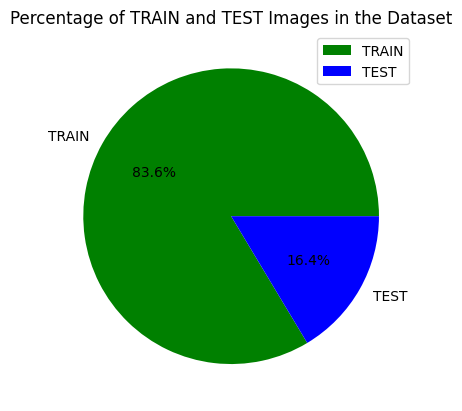

Number of 'Train' images: 97536
Number of 'Test' images: 19122


In [21]:
# Create a piechart

plt.pie([num_train, num_test], labels=["TRAIN", "TEST"], colors=["green", "blue"], autopct='%1.1f%%')
plt.title('Percentage of TRAIN and TEST Images in the Dataset')
plt.legend()
plt.show()
print("Number of 'Train' images:", num_train)
print("Number of 'Test' images:", num_test)

#### Next steps :
-   Investigate if it is needed to handle noisy data in the dataset

### 4. Data preprocessing

In [22]:
df.head()

,Filename,width,height,folder_type,tag
0,train/REAL/4053 (9).jpg,32,32,Train,REAL
1,train/REAL/2864 (4).jpg,32,32,Train,REAL
2,train/REAL/3536 (3).jpg,32,32,Train,REAL
3,train/REAL/0183 (8).jpg,32,32,Train,REAL
4,train/REAL/1607 (8).jpg,32,32,Train,REAL


In [23]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.metrics import accuracy_score
from sklearn.decomposition import PCA

from sklearn.linear_model import SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import LinearSVC
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier

2024-04-02 15:36:45.676422: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-02 15:36:45.676464: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-02 15:36:45.715439: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-04-02 15:36:45.794312: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


2024-04-02 15:36:46.496756: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [24]:
# Function preprocess image
def preprocess_image(image_path, target_size):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, target_size)
    image = tf.cast(image, tf.float32) / 255.0  # Normalize pixel values to [0, 1]
    return image

In [25]:
img_height = 32
img_width = 32
BATCH_SIZE = 32

In [26]:
image_paths = df["Filename"].copy().astype(str).tolist()
labels = df["tag"].copy().astype(str).tolist()

# Split the dataset into training and testing sets
X_train, X_test, Y_train, Y_test = train_test_split(image_paths, labels, test_size=0.2, random_state=42)

In [27]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
Y_train = le.fit_transform(Y_train)
Y_test = le.fit_transform(Y_test)
class_names = le.classes_

class_names

array(['FAKE', 'REAL'], dtype='<U4')

In [28]:
# Create TensorFlow datasets
train_ds = tf.data.Dataset.from_tensor_slices((X_train, Y_train))
test_ds = tf.data.Dataset.from_tensor_slices((X_test, Y_test))

# Map preprocessing function to the datasets
# train_dataset = train_ds.map(lambda x, y: (preprocess_image(x, target_size=(img_height, img_width)), y))
# test_dataset = test_ds.map(lambda x, y: (preprocess_image(x, target_size=(img_height, img_width)), y))
train_dataset = train_ds.cache().map(lambda x, y: (preprocess_image(x, target_size=(img_height, img_width)), y))
test_dataset = test_ds.cache().map(lambda x, y: (preprocess_image(x, target_size=(img_height, img_width)), y))

# shuffle and batch the datasets
train_dataset = train_dataset.shuffle(buffer_size=len(X_train)).batch(BATCH_SIZE)
test_dataset = test_dataset.batch(BATCH_SIZE)

2024-04-02 15:36:47.276864: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-04-02 15:36:47.364480: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-04-02 15:36:47.364639: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

In [29]:
# Iterate over the dataset (for demonstration)
for batch_images, batch_labels in train_dataset.take(1):
    numpy_array = batch_labels.numpy()
    print("Batch images shape:", batch_images.shape)
    print("length:", len(numpy_array))
    print("Fake num:", np.count_nonzero(numpy_array == 0))
    print("Real num:", np.count_nonzero(numpy_array == 1))
    # print(numpy_array)

Batch images shape: (32, 32, 32, 3)
length: 32
Fake num: 11
Real num: 21


In [30]:
# Checking that if pixels have been normalized as intended
for batch_images, batch_labels in train_dataset.take(1):
    print(f"Least value : {np.min(batch_images[0])}\nHighest value {np.max(batch_images[0])}")

Least value : 0.0
Highest value 1.0


- Checking if the images can still be visualised

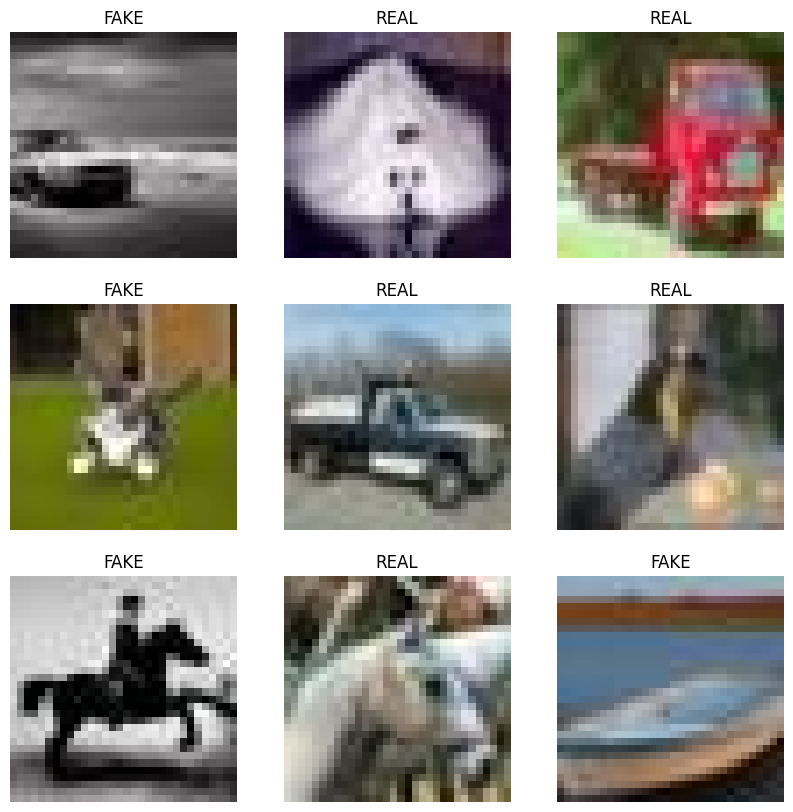

In [31]:
plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(np.reshape(images[i], (img_height,img_width,3)))
    plt.title(
      class_names[labels[i]]
    )
    plt.axis("off")

In [32]:
# Reshape dataset features to 2D
temp_x_train = []
train_labels_list = []
for batch_images, batch_labels in train_dataset:
    features = batch_images
    features = np.reshape(features, (features.shape[0], -1))
    temp_x_train.extend(features)
    train_labels_list.extend(batch_labels.numpy())

temp_x_test = []
test_labels_list = []
for batch_images, batch_labels in test_dataset:
    features = batch_images
    features = np.reshape(features, (features.shape[0], -1))
    temp_x_test.extend(features)
    test_labels_list.extend(batch_labels.numpy())

# Convert lists to arrays
Xr_train = np.array(temp_x_train)
Yr_train = np.array(train_labels_list)
Xr_test = np.array(temp_x_test)
Yr_test = np.array(test_labels_list)

In [33]:
Xr_train.shape

(93326, 3072)

In [34]:
Xr_test.shape

(23332, 3072)

In [35]:
# Using PCA to reduce the features dimensions for the reshaped training set
pca = PCA(n_components=0.99)
pcaX_train = pca.fit_transform(Xr_train)

In [36]:
pcaX_train.shape

(93326, 624)

In [37]:
# Reconstructing the images using pca inverse
X_reconstruct = pca.inverse_transform(pcaX_train)

#Recontructed training set dims
X_reconstruct.shape

(93326, 3072)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


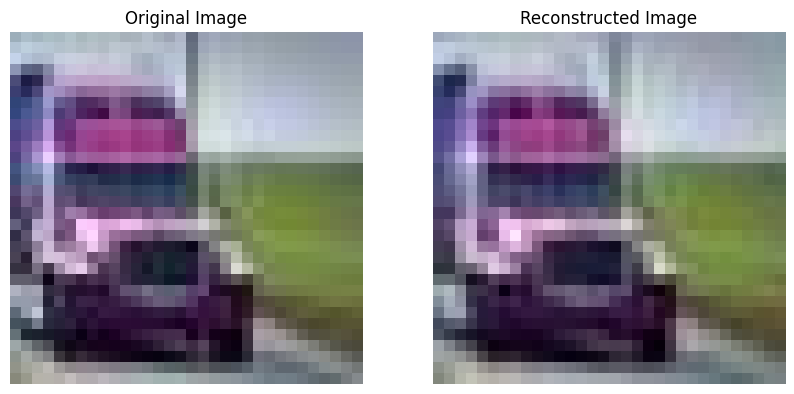

In [38]:
#Visualizing a sample reconstructed image
plt.figure(figsize=(10,5))
index = np.random.randint(X_reconstruct.shape[0])
plt.subplot(121)
plt.title("Original Image")
plt.imshow(np.reshape(Xr_train[index], (img_height,img_width,3)))
plt.axis('off')
plt.subplot(122)
plt.title("Reconstructed Image")
plt.imshow((np.reshape(X_reconstruct[index],(img_height, img_width,3))))
plt.axis('off')
plt.show()

- The visibility of the image was not significantly affected by reducing features with PCA, as we observed.

In [39]:
# pca_features_num = pcaX_train.shape[1]

# pca = PCA(n_components=pca_features_num)
# pcaX_test = pca.fit_transform(Xr_test)

# pcaX_test.shape

##### Training model using Classifier ML algorithms

In [40]:
import warnings

warnings.filterwarnings('ignore')

In [41]:
models = {}

#models with default parameter
models['SVC'] = LinearSVC(verbose=0, max_iter=500)
models['Random Forest'] = RandomForestClassifier(n_jobs=-1) # Set n_jobs to -1 to use all available cores
models['SGD'] = SGDClassifier()

In [42]:
performance_results = []

In [43]:
# use crossvalidate to on all the models to get the accuracy and f1-score
for name, model in models.items():
    scores = cross_validate(model, pcaX_train, Yr_train, cv=5, scoring=['accuracy', 'f1'], return_train_score=True)
    performance_results.append({
        "name": name, 
        "perf_train": scores['train_accuracy'].mean(), 
        "perf_test": scores['test_accuracy'].mean()
        })
    print(f"Model : {name}")
    print("Accuracy:" , 'train:', scores['train_accuracy'].mean(), '| test:', scores['test_accuracy'].mean())
    print("F1-score:" , 'train:', scores['train_f1'].mean(), '| test: ', scores['test_f1'].mean())
    print("-----------------------------------------------------------")

Model : SVC
Accuracy: train: 0.661045672488402 | test: 0.655690869790832
F1-score: train: 0.667004068580616 | test:  0.6616967812158843
-----------------------------------------------------------
Model : Random Forest
Accuracy: train: 1.0 | test: 0.7315431903747432
F1-score: train: 1.0 | test:  0.7152385935241463
-----------------------------------------------------------
Model : SGD
Accuracy: train: 0.6693954682486923 | test: 0.6605125618364522
F1-score: train: 0.672518828004239 | test:  0.6641894526565715
-----------------------------------------------------------


##### Training model using Neural Network algorithms

- Building a Convolutional Neural Networks (CNNs)

In [44]:
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [45]:
# Function preprocess image
def preprocess_image_ANN(image_path, target_size):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, target_size)
    # image = tf.cast(image, tf.float32) / 255.0  # Normalize pixel values to [0, 1]
    return image
# test_dir, train_dir = pathlib.Path('test/').with_suffix(''), pathlib.Path('train/').with_suffix('')

In [46]:
# image_count = len(list(train_dir.glob('*/*.jpg')))
# print(image_count)

In [47]:
AUTOTUNE = tf.data.AUTOTUNE

train_ann = train_dataset.prefetch(buffer_size=AUTOTUNE)
test_ann = test_dataset.prefetch(buffer_size=AUTOTUNE)
# train_ann = tf.keras.utils.image_dataset_from_directory(
#   train_dir,
#   validation_split=0.1,
#   subset="training",
#   seed=123,
#   image_size=(img_height, img_width),
#   batch_size=BATCH_SIZE)

# test_ann = tf.keras.utils.image_dataset_from_directory(
#   test_dir,
#   validation_split=0.9,
#   subset="validation",
#   seed=123,
#   image_size=(img_height, img_width),
#   batch_size=BATCH_SIZE)
# train_ann = train_ds.cache().map(lambda x, y: (preprocess_image_ANN(x, target_size=(img_height, img_width)), y)).prefetch(buffer_size=AUTOTUNE)
# test_ann = test_ds.cache().map(lambda x, y: (preprocess_image_ANN(x, target_size=(img_height, img_width)), y)).prefetch(buffer_size=AUTOTUNE)
# train_ann = train_ds
# test_ann = test_ds

# train_ann = train_ann.shuffle(buffer_size=len(X_train)).batch(BATCH_SIZE)
# test_ann = test_ann.batch(BATCH_SIZE)

In [48]:
for image_batch, labels_batch in test_ann.take(1):
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 32, 32, 3)
(32,)


In [49]:

num_classes = len(le.classes_)
# num_classes = len(train_ann.class_names)

model = Sequential([
  # layers.JpegDecoding(output_shape=(img_height, img_width, 3)),
  # layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu', 
                input_shape=(img_height, img_width, 3)
                ),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  # layers.BatchNormalization(),
  layers.Dense(num_classes),
])

In [50]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [51]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 32, 32, 16)        448       
                                                                 
 max_pooling2d (MaxPooling2  (None, 16, 16, 16)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 16, 16, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 8, 8, 32)          0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 8, 8, 64)          18496     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 4, 4, 64)          0

In [52]:
epochs=10
history = model.fit(
  train_ann,
  validation_data=test_ann,
  epochs=epochs,
  verbose=1
)

Epoch 1/10


2024-04-02 15:43:33.935481: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8902
2024-04-02 15:43:34.022849: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory


2024-04-02 15:43:34.311353: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2024-04-02 15:43:34.371183: I external/local_xla/xla/service/service.cc:168] XLA service 0x7f16147667e0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-04-02 15:43:34.371199: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 3060, Compute Capability 8.6
2024-04-02 15:43:34.380276: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1712072614.448965    2756 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


2917/2917 [==============================] - 12s 3ms/step - loss: 0.2772 - accuracy: 0.8819 - val_loss: 0.2142 - val_accuracy: 0.9124
Epoch 2/10
2917/2917 [==============================] - 10s 3ms/step - loss: 0.1884 - accuracy: 0.9255 - val_loss: 0.1825 - val_accuracy: 0.9292
Epoch 3/10
2917/2917 [==============================] - 9s 3ms/step - loss: 0.1648 - accuracy: 0.9353 - val_loss: 0.1683 - val_accuracy: 0.9330
Epoch 4/10
2917/2917 [==============================] - 10s 3ms/step - loss: 0.1483 - accuracy: 0.9416 - val_loss: 0.1636 - val_accuracy: 0.9368
Epoch 5/10
2917/2917 [==============================] - 10s 3ms/step - loss: 0.1330 - accuracy: 0.9483 - val_loss: 0.1993 - val_accuracy: 0.9226
Epoch 6/10
2917/2917 [==============================] - 10s 3ms/step - loss: 0.1201 - accuracy: 0.9531 - val_loss: 0.1775 - val_accuracy: 0.9308
Epoch 7/10
2917/2917 [==============================] - 10s 3ms/step - loss: 0.1083 - accuracy: 0.9575 - val_loss: 0.1714 - val_accuracy: 0.93

In [53]:
cnn_train_val, cnn_test_val = model.evaluate(train_ann)[1], model.evaluate(test_ann)[1]

# Add performance inside variable
performance_results.append({"name": "CNN", "perf_train": cnn_train_val, "perf_test": cnn_test_val})

730/730 [==============================] - 1s 956us/step - loss: 0.1806 - accuracy: 0.9436


In [54]:
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from keras import regularizers
# from lime import lime_image
# from skimage.segmentation import mark_boundaries

In [55]:
# # Define the explainer
# explainer = lime_image.LimeImageExplainer()

# # Generate an explanation for a sample image
# sample_image = np.array(Image.open('sample_image.jpg').resize((32, 32)))
# explanation = explainer.explain_instance(sample_image, model.predict, top_labels=5, hide_color=0, num_samples=1000)

# # Visualize the explanation
# temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=True, num_features=5, hide_rest=False)
# plt.imshow(mark_boundaries(sample_image, mask))
# plt.show()

In [56]:
# Build a ResNet model
# model = Sequential([
#     tf.keras.applications.ResNet50(input_shape=(img_height, img_width, 3),
#               include_top=False,
#               weights='imagenet'),
#     tf.keras.layers.Flatten(),
#     tf.keras.layers.Dense(128, activation='relu'),
#     tf.keras.layers.Dense(num_classes, activation='softmax')
# ])

# # Compile the model
# model.compile(optimizer='adam',
#               loss='sparse_categorical_crossentropy',
#               metrics=['accuracy'])

# # Train the model
# history = model.fit(train_ann, epochs=10, validation_data=test_ann)

In [57]:
# Performance Comparison 
valid_accuracy = [x["perf_train"] for x in performance_results]
test_accuracy = [x["perf_test"] for x in performance_results]
index = [x["name"] for x in performance_results]

# print(value["name"])
accuracy_df = pd.DataFrame({'Train Accuracy':valid_accuracy,'Test Accuracy':test_accuracy},index=index)
accuracy_df

,Train Accuracy,Test Accuracy
SVC,0.661046,0.655691
Random Forest,1.000000,0.731543
SGD,0.669395,0.660513
CNN,0.978655,0.943554


<Axes: title={'center': 'Performance Comparison'}>

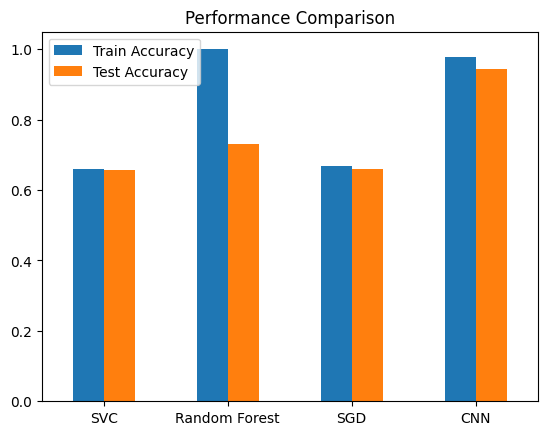

In [58]:
accuracy_df.plot.bar(rot=0, title = 'Performance Comparison')

- The model that has the best performance is CNN

- It seems that the model is overfitting to the training dataset since the loss result on the training is not as good as on the testing set.

### 5. Data augmentation & Hyperparameter tuning

- To solve overfitting we will apply 
    - Data augmentation
    - Dropout
    - Regularization

In [59]:
data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal",
                      input_shape=(img_height,
                                  img_width,
                                  3)),
    # layers.RandomRotation(0.1),
    # layers.RandomZoom(0.1),
    # layers.RandomBrightness(0.001),
    # layers.RandomContrast(0.4)
  ]
)

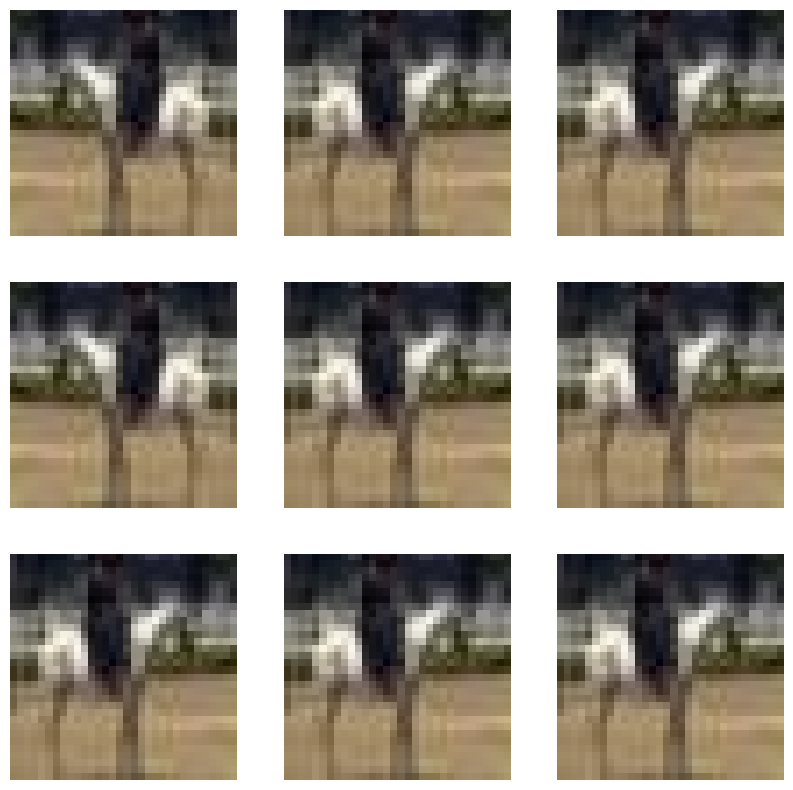

In [60]:
# Visualise the effect of the data visualisation
plt.figure(figsize=(10, 10))
for images, _ in train_ann.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow((np.reshape(augmented_images[0],(img_height, img_width,3))))
    plt.axis("off")

- In order to prevent the model to overfit, the model complexity has been reduced.
- To reduce the complexity these actions has been done :
    1. We reduced the number of convolutional layers from three to two.
    2. We reduced the number of units in the Dense layer from 128 to 64.

In [61]:
# model_augmentation = Sequential([
#   data_augmentation,
#   # layers.Rescaling(1./255),
#   layers.Conv2D(16, 3, padding='same', activation='relu', input_shape=(img_height, img_width, 3)),
#   layers.MaxPooling2D(),
  
#   layers.Conv2D(32, 3, padding='same', activation='relu'),
#   layers.MaxPooling2D(),
  
#   layers.Conv2D(64, 3, padding='same', activation='relu'),
#   layers.MaxPooling2D(),
  
#   layers.Flatten(),
  
#   layers.Dropout(0.5),
  
#   layers.Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
#   layers.Dense(1, activation='sigmoid')
# ])

model_augmentation = Sequential([
  data_augmentation,
  # layers.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  
  layers.Dropout(0.5),
  
  layers.Flatten(),
  
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes, name="outputs")
  # layers.Dense(1, ac)
])

In [62]:
# model_augmentation.compile(optimizer='adam',
#               loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
#               metrics=['accuracy'])
model_augmentation.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [63]:
model_augmentation.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_1 (Sequential)   (None, 32, 32, 3)         0         
                                                                 
 conv2d_3 (Conv2D)           (None, 32, 32, 16)        448       
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 16, 16, 16)        0         
 g2D)                                                            
                                                                 
 conv2d_4 (Conv2D)           (None, 16, 16, 32)        4640      
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 8, 8, 32)          0         
 g2D)                                                            
                                                                 
 conv2d_5 (Conv2D)           (None, 8, 8, 64)         

In [64]:
epochs = 15

# Helps monitor the validation loss and stops training when it starts to increase
early_stopping = tf.keras.callbacks.EarlyStopping(monitor = 'val_loss', patience = 3, restore_best_weights = True)

history_augmentation = model_augmentation.fit(
  train_ann,
  validation_data=test_ann,
  epochs=epochs,
  callbacks = [early_stopping]
)

Epoch 1/15


2024-04-02 15:45:19.087430: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_2/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


2917/2917 [==============================] - 13s 4ms/step - loss: 0.2948 - accuracy: 0.8744 - val_loss: 0.2539 - val_accuracy: 0.8945
Epoch 2/15
2917/2917 [==============================] - 11s 3ms/step - loss: 0.2107 - accuracy: 0.9157 - val_loss: 0.1803 - val_accuracy: 0.9280
Epoch 3/15
2917/2917 [==============================] - 11s 3ms/step - loss: 0.1930 - accuracy: 0.9240 - val_loss: 0.1950 - val_accuracy: 0.9263
Epoch 4/15
2917/2917 [==============================] - 11s 3ms/step - loss: 0.1790 - accuracy: 0.9290 - val_loss: 0.1511 - val_accuracy: 0.9427
Epoch 5/15
2917/2917 [==============================] - 11s 3ms/step - loss: 0.1689 - accuracy: 0.9337 - val_loss: 0.1762 - val_accuracy: 0.9305
Epoch 6/15
2917/2917 [==============================] - 11s 3ms/step - loss: 0.1618 - accuracy: 0.9380 - val_loss: 0.1502 - val_accuracy: 0.9424
Epoch 7/15
2917/2917 [==============================] - 11s 3ms/step - loss: 0.1555 - accuracy: 0.9386 - val_loss: 0.1368 - val_accuracy: 0.9

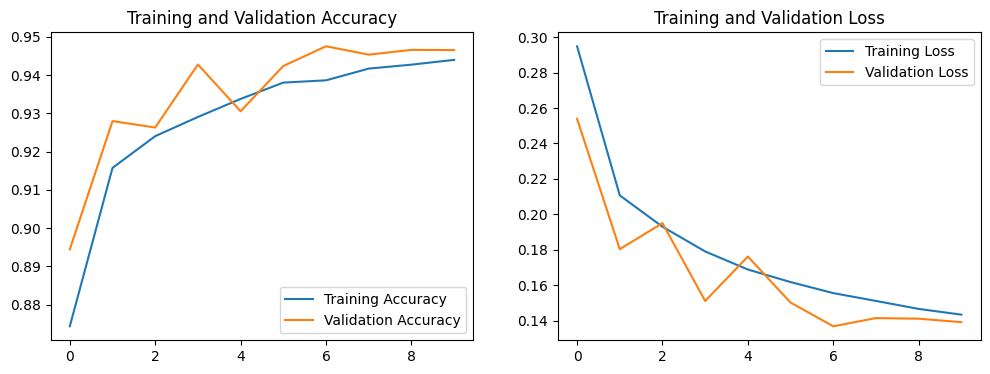

In [65]:
acc = history_augmentation.history['accuracy']
val_acc = history_augmentation.history['val_accuracy']

loss = history_augmentation.history['loss']
val_loss = history_augmentation.history['val_loss']

epochs_range = range(
    len(history_augmentation.history['accuracy'])
    )

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

- reduced model overfitting

### 6. Evaluating performance

In [94]:
from tensorflow.keras.metrics import Precision, Recall, Accuracy

In [95]:
precision_acc = Precision()
recall_acc = Recall()
model_accuracy = Accuracy()

In [96]:
for batch in test_ann.take(1):
    X, y = batch
    y_predict = model_augmentation.predict(X)
    y_predict = y_predict.argmax(axis=1)
    precision_acc.update_state(y, y_predict)
    recall_acc.update_state(y, y_predict)
    model_accuracy.update_state(y, y_predict)

1/1 [==============================] - 0s 12ms/step


In [97]:
print(f"Precision: {precision_acc.result().numpy()}\nRecall: {recall_acc.result().numpy()}\nAccurancy: {model_accuracy.result().numpy()}")

Precision: 0.9285714030265808
Recall: 0.9285714030265808
Accurancy: 0.9375


- Predicting random images if it is real or ai-generated

In [116]:
import re

def get_input_type(value: str) -> str:
    pattern = r"REAL|FAKE"
    match = re.search(pattern, value)
    if match:
        return match.group()
    else:
        return None


random_index = np.random.randint(len(X_test) - 1)
test_input = X_test[random_index].replace(".jpg", "")

new_data = pathlib.Path(test_input).with_suffix('.jpg')
img = tf.keras.utils.load_img(
    new_data, target_size=(img_height, img_width)
)
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model_augmentation.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "===> The input image type is {}"
    .format(get_input_type(test_input))
)

print(
    "===> The model predicted the image to be {} with a {:.1f}% confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

1/1 [==============================] - 0s 13ms/step
===> The input image type is FAKE
===> The model predicted the image to be FAKE with a 100.0% confidence.
